In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_adata(adata_to_plot, cluster_key, plot_type="umap", keyword=None):
    """
    Plot AnnData embeddings (UMAP or spatial).
    
    Parameters:
    - adata_to_plot: AnnData object with .obsm and .obs fields.
    - cluster_key: key in adata.obs to color by.
    - plot_type: "umap" or "spatial".
    - keyword: if provided, only highlight clusters containing this substring; others grouped as "Other".
    """

    # Prepare DataFrame for plotting
    if plot_type == "spatial":
        coords = adata_to_plot.obsm['spatial'].copy()
        df = pd.DataFrame(coords, columns=['x', 'y'], index=adata_to_plot.obs_names)
    else:  # UMAP
        df = pd.DataFrame(
            adata_to_plot.obsm['X_umap'],
            columns=['UMAP1', 'UMAP2'],
            index=adata_to_plot.obs_names
        )

    # Original cluster labels as strings
    df[cluster_key] = adata_to_plot.obs[cluster_key].astype(str)

    # If a keyword is provided, label matching clusters, others as "Other"
    if keyword:
        df['plot_label'] = df[cluster_key].apply(lambda x: x if keyword in x else 'Other')
        color_key = 'plot_label'
        legend_title = f"Highlighted: {keyword}"
    else:
        color_key = cluster_key
        legend_title = cluster_key

    # Get a discrete color map
    tab20 = [mpl.colors.rgb2hex(c) for c in plt.get_cmap('tab20').colors]

    # Choose appropriate scatter fields
    if plot_type == "spatial":
        fig = px.scatter(
            df,
            x='x',
            y='y',
            color=color_key,
            title='Spatial scatter — manual cell types',
            hover_name=df.index,
            width=1600,
            height=700
        )
        fig.update_traces(marker=dict(size=2, opacity=0.8))
        fig.update_yaxes(autorange='reversed')
    else:  # UMAP
        fig = px.scatter(
            df,
            x='UMAP1',
            y='UMAP2',
            color=color_key,
            title='UMAP embedding — Leiden clusters',
            color_discrete_sequence=tab20,
            hover_name=df.index,
            width=1400,
            height=1200
        )
        fig.update_traces(marker=dict(size=3, opacity=0.8))

    # Adjust legend and layout
    fig.update_layout(
        legend_title_text=legend_title,
        legend=dict(
            itemsizing='constant',
            traceorder='normal',
            bgcolor='rgba(255,255,255,0.5)',
            x=1.02,
            y=1
        ),
        margin=dict(l=20, r=200, t=50, b=20)
    )

    fig.show()

In [2]:
import pandas as pd
import scanpy as sc

MajorSet = "Mesenchymal_Subtypes"
Tissue = "Region3"
xen_file = f"/Volumes/ProstateCancerEvoMain/dbs/Ongoing/Collection/MajorAnnGroups/{MajorSet}/{Tissue}.{MajorSet}.h5ad"
adata_xen = sc.read_h5ad(xen_file) 
adata_xen



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/ugursahin/miniforge3/envs/ScanPy/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/ugursahin/miniforge3/envs/ScanPy/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/ugursahin/miniforge3/envs/ScanPy/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in

AnnData object with n_obs × n_vars = 38773 × 5101
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'cell_type', 'leiden', 'major_cell_type_xenium_panel'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_leiden', 'spatialdata_attrs', 'umap'
    obsm: 'X_pca', '

In [3]:
ann_file = f"/Volumes/ProstateCancerEvoMain/dbs/Ongoing/Collection/MajorAnnGroups/{MajorSet}/{MajorSet}.V1.xlsx"

df = pd.read_excel(ann_file)


# 2. Split the comma-separated 'geneSymbolmore1' column into lists
df["gene_list"] = df["geneSymbolmore1"].str.split(",")

# 3. Explode the 'gene_list' column so each (cellName, gene) pair is its own row
df_long = df.explode("gene_list")

# 4. (Optional) Trim whitespace from each gene symbol, in case there are stray spaces
df_long["gene_list"] = df_long["gene_list"].str.strip()

# 5. Select (and/or rename) only the columns you need: 'cellName' and the exploded gene symbol
df_long = df_long[["cellName", "gene_list"]].rename(columns={"gene_list": "geneSymbol"})

# 6. Reset the index (optional, for a clean range index)
markers = df_long.reset_index(drop=True)
markers

dup_mask = markers["geneSymbol"].duplicated(keep=False)

markers = markers[~dup_mask].copy()


In [4]:
import spatialdata
import anndata
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import decoupler as dc

dc.run_ora(
    mat=adata_xen,
    net=markers,
    source='cellName',
    target='geneSymbol',
    min_n=3,
    verbose=True,
    use_raw=False
)

adata_xen.obsm['ora_estimate']

acts = dc.get_acts(adata_xen, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed for pvals=0
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

acts

/Users/ugursahin/miniforge3/envs/ScanPy/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/ugursahin/miniforge3/envs/ScanPy/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)
/Users/ugursahin/miniforge3/envs/ScanPy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Running ora on mat with 38773 samples and 5101 targets for 5 sources.


100%|██████████| 38773/38773 [00:31<00:00, 1240.64it/s]


AnnData object with n_obs × n_vars = 38773 × 5
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'cell_type', 'leiden', 'major_cell_type_xenium_panel'
    uns: 'cell_type_colors', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_leiden', 'spatialdata_attrs', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'ora_estimate', 'ora_pvals'

In [5]:
res = dc.rank_sources_groups(acts, groupby='leiden', reference='rest', method='t-test_overestim_var')
res

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,0,rest,fibroblast_of_connective_tissue_of_glandular_p...,47.382732,1.033276,0.000000e+00,0.000000e+00
1,0,rest,fibroblast_of_connective_tissue_of_nonglandula...,25.864311,0.370301,0.000000e+00,0.000000e+00
2,0,rest,pericyte,3.233332,0.066618,1.227138e-03,1.227138e-03
3,0,rest,prostate_gland_microvascular_endothelial_cell,-21.405981,-1.046874,0.000000e+00,0.000000e+00
4,0,rest,smooth_muscle_cell_of_prostate,-33.414589,-0.996625,0.000000e+00,0.000000e+00
5,1,rest,smooth_muscle_cell_of_prostate,20.730976,0.746521,0.000000e+00,0.000000e+00
6,1,rest,fibroblast_of_connective_tissue_of_nonglandula...,-25.136787,-0.292361,0.000000e+00,0.000000e+00
7,1,rest,pericyte,-26.787636,-0.520037,0.000000e+00,0.000000e+00
8,1,rest,fibroblast_of_connective_tissue_of_glandular_p...,-28.818913,-0.487332,0.000000e+00,0.000000e+00
9,1,rest,prostate_gland_microvascular_endothelial_cell,-35.568455,-1.785986,0.000000e+00,0.000000e+00


In [6]:
n_ctypes = 5
ctypes_dict = res.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
ctypes_dict

{'0': ['fibroblast_of_connective_tissue_of_glandular_part_of_prostate',
  'fibroblast_of_connective_tissue_of_nonglandular_part_of_prostate',
  'pericyte',
  'prostate_gland_microvascular_endothelial_cell',
  'smooth_muscle_cell_of_prostate'],
 '1': ['smooth_muscle_cell_of_prostate',
  'fibroblast_of_connective_tissue_of_nonglandular_part_of_prostate',
  'pericyte',
  'fibroblast_of_connective_tissue_of_glandular_part_of_prostate',
  'prostate_gland_microvascular_endothelial_cell'],
 '10': ['pericyte',
  'prostate_gland_microvascular_endothelial_cell',
  'fibroblast_of_connective_tissue_of_nonglandular_part_of_prostate',
  'fibroblast_of_connective_tissue_of_glandular_part_of_prostate',
  'smooth_muscle_cell_of_prostate'],
 '11': ['smooth_muscle_cell_of_prostate',
  'pericyte',
  'fibroblast_of_connective_tissue_of_nonglandular_part_of_prostate',
  'fibroblast_of_connective_tissue_of_glandular_part_of_prostate',
  'prostate_gland_microvascular_endothelial_cell'],
 '2': ['smooth_muscle_

In [7]:
# If adata_xen.obs['leiden'] is integer-typed, convert to string so it matches ctypes_dict keys:
if pd.api.types.is_integer_dtype(adata_xen.obs['leiden']):
    adata_xen.obs['leiden'] = adata_xen.obs['leiden'].astype(str)

# 4) Create a new column "assigned_celltype" by mapping each cell's cluster to ctypes_dict[cluster][0]
def pick_first_celltype(cluster_label):
    # Return the first element of the list in ctypes_dict, if the key exists
    if cluster_label in ctypes_dict:
        return ctypes_dict[cluster_label][0]
    else:
        return None

adata_xen.obs['assigned_celltype'] = adata_xen.obs['leiden'].map(pick_first_celltype)


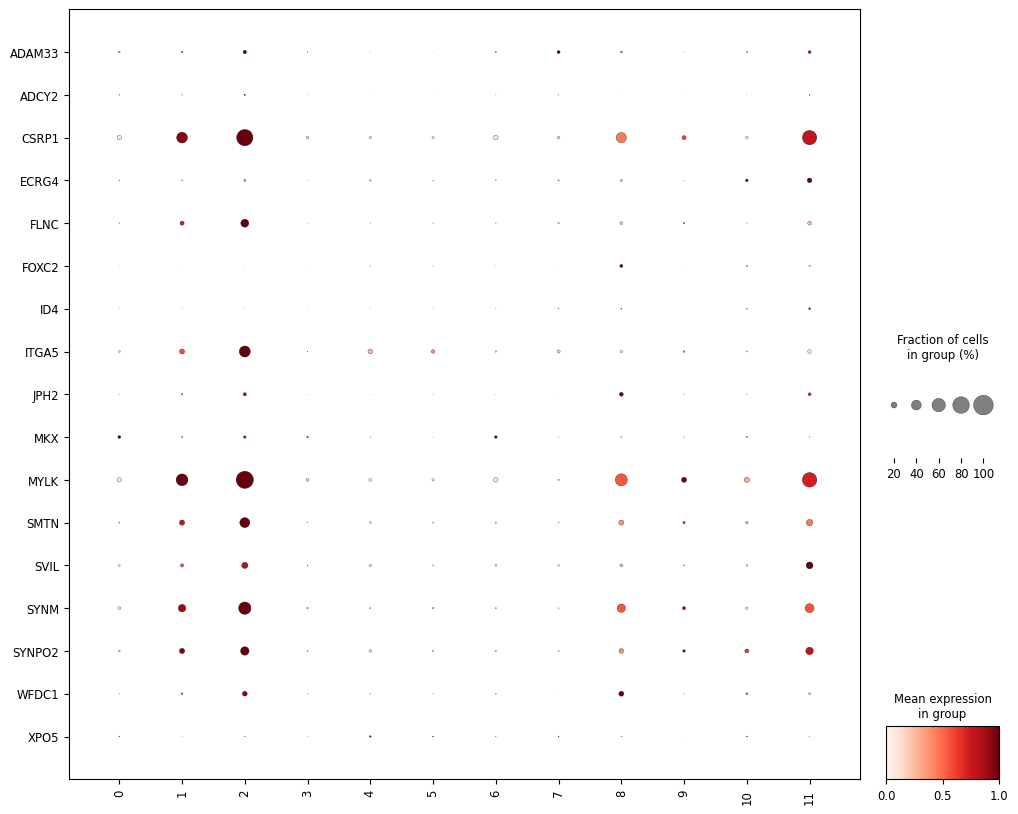

In [16]:
pericytes = list(markers[markers["cellName"]=="smooth_muscle_cell_of_prostate"]["geneSymbol"].values)

present = [g for g in pericytes if g in list(adata_xen.var_names)]

# Create the dotplot
sc.pl.dotplot(
    adata_xen,
    present,
    groupby="leiden",
    standard_scale='var',   # scale each gene to [0,1] across groups
    swap_axes=True,
    dendrogram=False,
    dot_max=1,
    figsize=(12, 10),
)


In [9]:
plot_adata(adata_xen,cluster_key="leiden")

In [10]:
plot_adata(adata_xen,cluster_key="assigned_celltype")

In [11]:
set(markers["cellName"].values)

{'fibroblast_of_connective_tissue_of_glandular_part_of_prostate',
 'fibroblast_of_connective_tissue_of_nonglandular_part_of_prostate',
 'pericyte',
 'prostate_gland_microvascular_endothelial_cell',
 'smooth_muscle_cell_of_prostate'}

In [17]:
#Edit 
if Tissue == "Region1":
    #checked
    adata_xen.obs.loc[adata_xen.obs["leiden"] == "9", "assigned_celltype"] = "neuron_cell"
    pass
if Tissue == "Region2":
    #checked
    pass
if Tissue == "Region3":
    #checked
    pass
if Tissue == "Region4":
    #checked
    pass


In [18]:
plot_adata(adata_xen,cluster_key="assigned_celltype")

In [14]:
# outpath = "/Volumes/ProstateCancerEvoMain/dbs/Ongoing/Collection/MajorAnnGroups/Results"
# adata_xen.write_h5ad(
#               f"{outpath}/{Tissue}/{xen_file.split('/')[-1].replace('.h5ad','.AnnDC.h5ad')}")

# f"{outpath}/{Tissue}/{xen_file.split('/')[-1].replace('.h5ad','.AnnDC.h5ad')}"
